In [120]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Classifier -- the 2nd version

In this version of the classifier, the power line frequencies are removed before fitting the models.

In [77]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [78]:
def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

In [79]:
keep = np.where((feature_info['Frequency'] < 50) | (feature_info['Frequency'] > 70))[0]

feature_info = feature_info.iloc[keep, :]
feature_matrix = feature_matrix.iloc[keep, :]

assert len(feature_info) == feature_matrix.shape[0]
assert len(key) == feature_matrix.shape[1]

In [80]:
# Drop power line frequencies (between 50 and 70 Hz)
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel,')
print('          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')


The feature matrix has 3584 features and 4150 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel,
          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


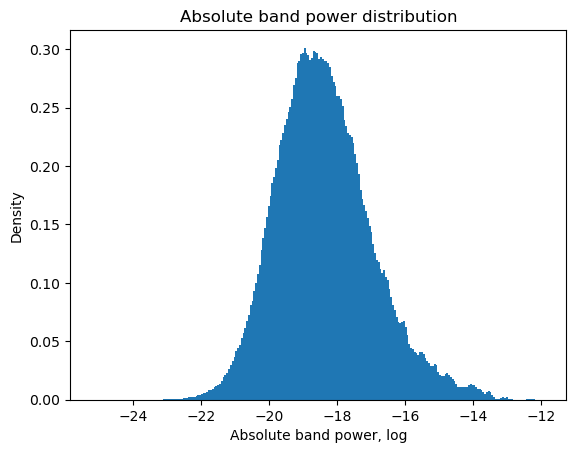

In [81]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 250, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

After natural log transformation, the complete dataset displays a normal distribution. Thus, z-scale transformation can be applied on the data.

## Filter out non-informative features

Non-informative features will be filtered out before training the models. Non-informative features are those that have an extremely low coefficient of variation. For the data that is log-normally distributed an estimate of coefficient of variation is defined as:

$$\hat{cv} = \sqrt{e^{s^{2}_{ln}} - 1}$$

where $s_{ln}$ is the standard deviation of the data after the natural log transformation.

In [82]:
# Log-transform
x = np.log(feature_matrix.values)

# Center
x = x.T - np.mean(x, axis = 1)
x = x.T

cv = np.sqrt(np.power(np.e, np.power(np.std(x, axis = 1), 2)) - 1)
assert len(cv) != len(key)

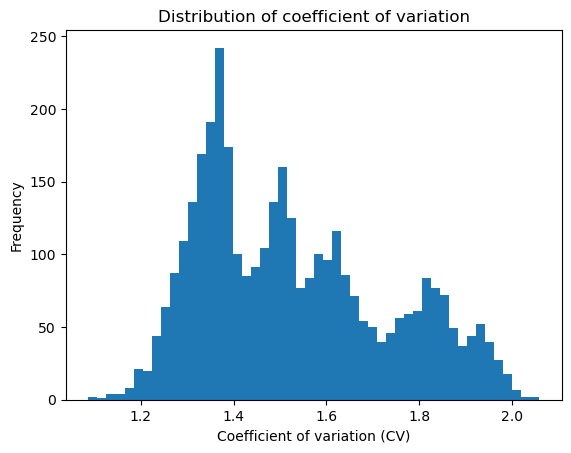

In [83]:
plt.hist(cv, bins = 50)
plt.xlabel('Coefficient of variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of coefficient of variation')
plt.show()

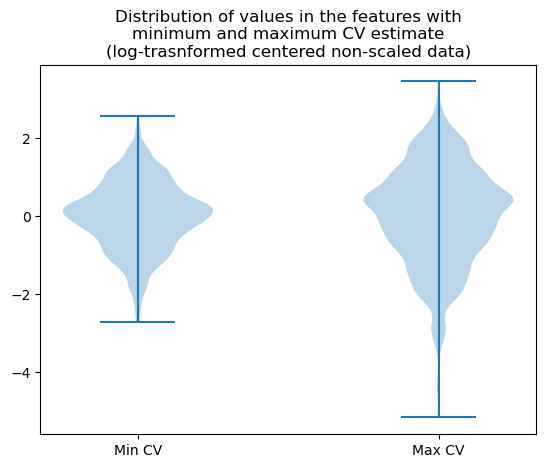

In [84]:
idx_max = np.argmax(cv)
idx_min = np.argmin(cv)

plt.violinplot(x[[idx_min, idx_max], :].T)
plt.title(
    'Distribution of values in the features with\nminimum and maximum CV estimate\n(log-trasnformed centered non-scaled data)')
plt.xticks([1, 2], ['Min CV', 'Max CV'])
plt.show()

The CV seems quite high for all the features, and the data is well distributed for both the minimal and the maximal CV values. Seems like all the features carry some information that may be useful to the classifier. Keeping all the features for now.

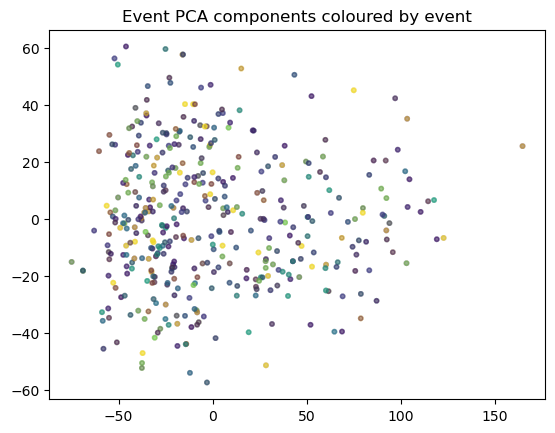

In [85]:
pca = PCA(n_components = 2).fit_transform(x.T)
assert pca.shape[0] == len(key)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Event']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by event')
plt.show()

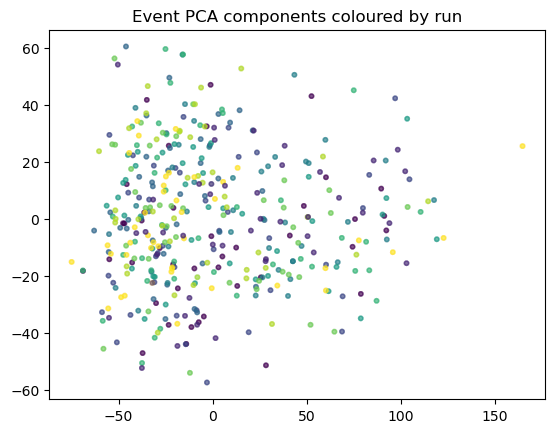

In [86]:
plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Run']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by run')
plt.show()

In the PCA plot, there seems to be no separation by finger. Which is quite sad. However, there's no separation by run as well which is good.

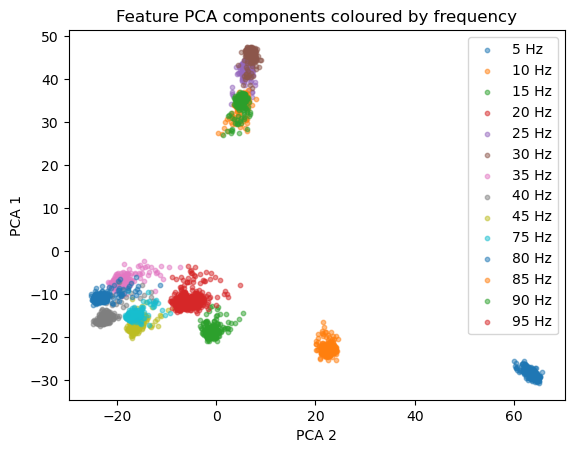

In [106]:
for frequency in np.unique(feature_info['Frequency']):
    freq_idx = feature_info['Frequency'] == frequency
    pca_x = pca[freq_idx, 0]
    pca_y = pca[freq_idx, 1]
    plt.scatter(pca_y, pca_x,
                label = f'{frequency} Hz',
                s = 10,
                alpha = 0.5)

plt.title('Feature PCA components coloured by frequency')
plt.xlabel('PCA 2')
plt.ylabel('PCA 1')
plt.legend()
plt.show()

## Classifier

### Finger classifier

In [108]:
def create_splits(x, y, n_splits = 5):
    validator = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True)

    splits = []
    for train_ix, test_ix in validator.split(x, y):
        x_train, y_train = x[train_ix], y[train_ix]
        x_test, y_test = x[test_ix], y[test_ix]
        splits.append([x_train, y_train, x_test, y_test])

    return splits

In [111]:
def calculate_model_metrics(models, model_splits):
    model_results = []

    for model_i, split_i in zip(models, model_splits):
        train_x, train_y, test_x, test_y = split_i

        predicted_y = model_i.predict(test_x)

        model_results.append({
            'Accuracy': model_i.score(test_x, test_y),
            'TrainAccuracy': model_i.score(train_x, train_y),
            'MeanPrecisionPerClass': np.mean(precision_score(test_y, predicted_y, average = None)),
            'MeanRecallPerClass': np.mean(recall_score(test_y, predicted_y, average = None))
        })

    return pd.DataFrame(model_results)

In [109]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Select only finger movement data
x = x[y != 0, :]
y = y[y != 0]

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

#### Random forest

In [110]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={1: 1.0, 2: 1.0,
                                                            3: 1.0, 4: 1.0,
                                                            5: 1.0},
                                              criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='f1_macro', verbose=3)

In [112]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best set of hyperparameters:  {'max_depth': 8, 'n_estimators': 16}
Best score:  0.22685972149549327


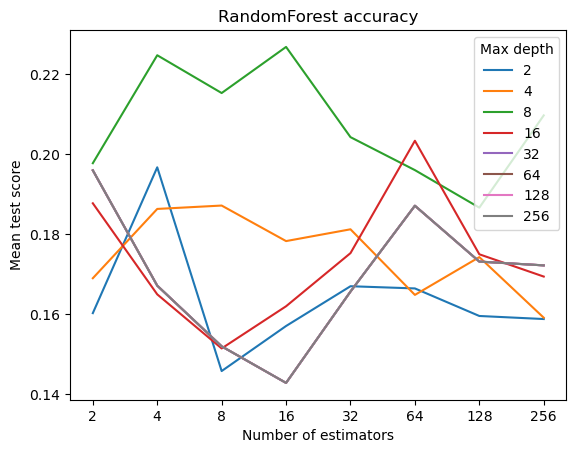

In [113]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [114]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)
    random_forest_fingers.append(model)

Starting another split
Starting another split
Starting another split
Starting another split
Starting another split


In [115]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

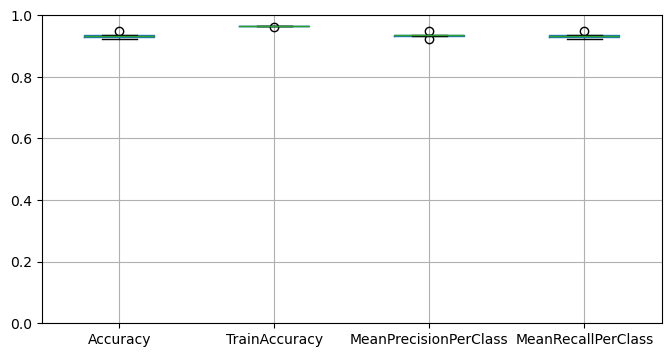

In [116]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [117]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

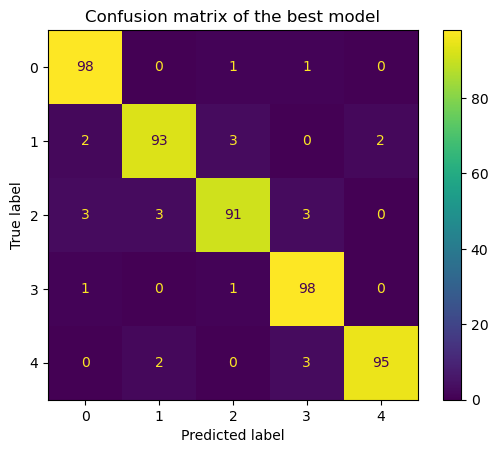

In [118]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

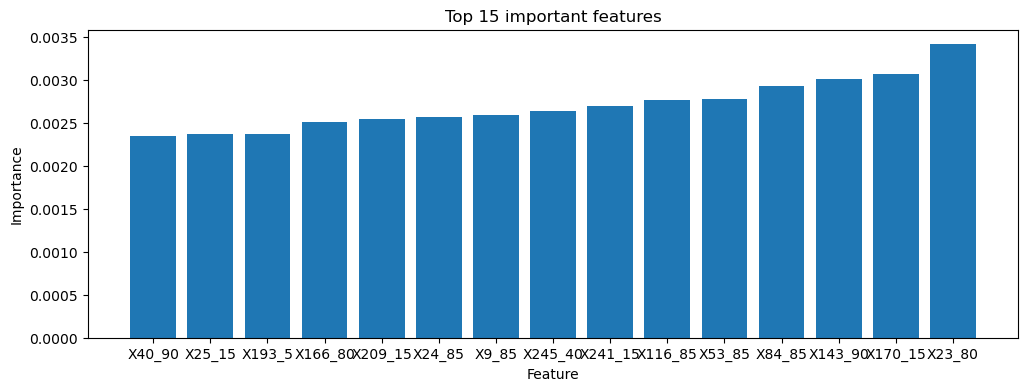

In [119]:
plt.figure(figsize = (12, 4))
importance = model.feature_importances_
forest_importance = pd.Series(importance, index = feature_matrix.index)
forest_importance = forest_importance.sort_values()

plt.bar(x = forest_importance[-15:].index, height = forest_importance[-15:])
plt.title('Top 15 important features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

#### Neural network model

In [127]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'hidden_layer_sizes': [2, 4, 8, 16, 32, 64],
    # 'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032, 0.0064],
    'learning_rate_init': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064]
}

model = MLPClassifier(
    random_state = 42,
    verbose = False,
    learning_rate = 'constant',
    shuffle = True,
    early_stopping = True,
    solver = 'adam',
    activation = 'relu',
    validation_fraction = 0.1,
    max_iter = 500
)

grid_search = GridSearchCV(model, param_grid, cv = 3, scoring = 'f1_macro', verbose = 3, n_jobs = 6)
grid_search.fit(x, y)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     random_state=42),
             n_jobs=6,
             param_grid={'alpha': [0.0001, 0.0002, 0.0004, 0.0008, 0.0016,
                                   0.0032, 0.0064],
                         'hidden_layer_sizes': [2, 4, 8, 16, 32, 64],
                         'learning_rate_init': [0.001, 0.002, 0.004, 0.008,
                                                0.016, 0.032, 0.064]},
             scoring='f1_macro', verbose=3)

In [128]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'alpha': 0.0064, 'hidden_layer_sizes': 4, 'learning_rate_init': 0.064}
Best score:  0.2352557335956337


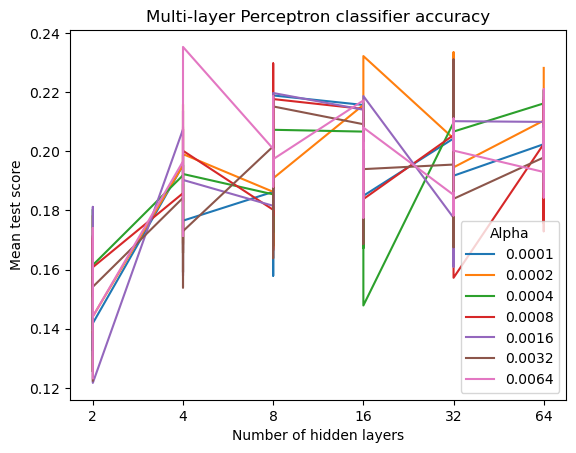

In [175]:
results = pd.DataFrame(grid_search.cv_results_)

for alpha in np.sort(np.unique(results['param_alpha'])):
    res = results[results['param_alpha'] == alpha]
    plt.plot(np.log(res['param_hidden_layer_sizes'].astype(float)), res['mean_test_score'], label = alpha)

plt.legend(title = 'Alpha')
plt.xticks(np.log([2, 4, 8, 16, 32, 64]), np.array([2, 4, 8, 16, 32, 64]))
plt.title('Multi-layer Perceptron classifier accuracy')
plt.xlabel('Number of hidden layers')
plt.ylabel('Mean test score')
plt.show()

In [136]:
alpha = grid_search.best_params_['alpha']
hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']
learning_rate_init = grid_search.best_params_['learning_rate_init']

Seems like the parameters for the neural network model have to be estimated for each split separately, as the parameters calculated for the whole dataset did not produce the best result. Right now, for the sake of simplicity, this will not be done. However, I plan to implement such strategy when fitting the final models for all the samples.

In [212]:
mlp_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = MLPClassifier(
        random_state = 42,
        verbose = False,
        learning_rate = 'adaptive',
        shuffle = True,
        early_stopping = True,
        solver = 'adam',
        activation = 'relu',
        validation_fraction = 0.1,
        max_iter = 500,
        alpha = alpha * 2,
        hidden_layer_sizes = 256,
        learning_rate_init = learning_rate_init / 2
    )

    model.fit(x_train, y_train)

    print(f'Model training accuracy: {model.score(x_train, y_train)}')
    print(f'Model testing accuracy: {model.score(x_test, y_test)}')

    mlp_fingers.append(model)

Starting another split
Model training accuracy: 0.9395
Model testing accuracy: 0.906
Starting another split
Model training accuracy: 0.927
Model testing accuracy: 0.898
Starting another split
Model training accuracy: 0.9515
Model testing accuracy: 0.94
Starting another split
Model training accuracy: 0.9415
Model testing accuracy: 0.9
Starting another split
Model training accuracy: 0.909
Model testing accuracy: 0.892


In [213]:
mlp_eval = calculate_model_metrics(models = mlp_fingers, model_splits = splits)

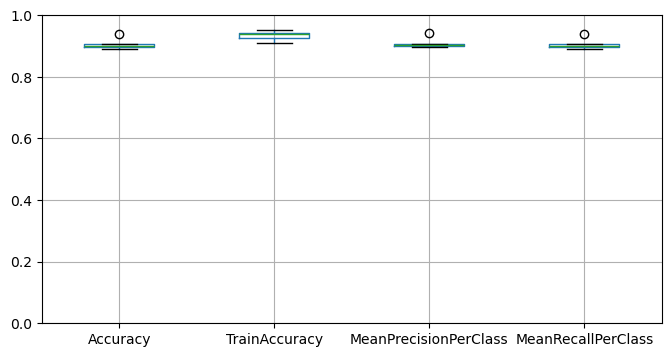

In [214]:
plt.figure(figsize = (8, 4))
mlp_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [215]:
best_model_idx = np.argmax(mlp_eval['Accuracy'])
model = mlp_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

In [216]:
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.9515
0.94


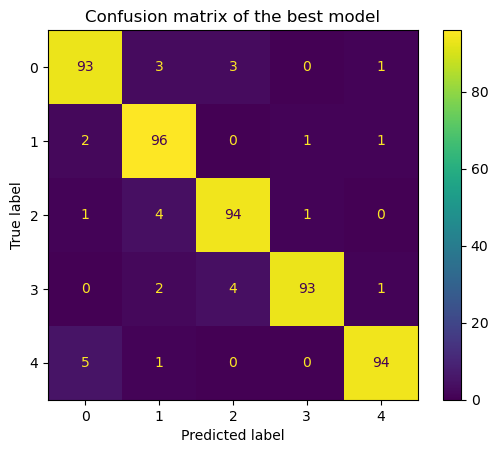

In [217]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

The neural network model did not produce drastically better results than much simpler random forest classifier.